In [26]:
dataname="trg_multi"
#dataname='trg-multires-7classes-10x'
fname = '../../../data/test/slide1.png'
modelpath = "../../models/multi/multires-7classes-10x-v0.pth" 
network = 'MergeSmallNetworks'
n_classes =7

#class_names=["Fat", "Muscular", "Vessle", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"]
class_names = ["Fat", "Muscular", "Vessle", "Gland", "Stroma", "Tumor", "Epithelium"]
modulepath = '/home/ltran/trg_ltran/'
nclasses=len(class_names)

# resize, padsize, patch_size and batch_size used for the model 
resize_resolutions=[1,.25] #resize input image, base and second
patch_size=64
patch_size_res2 = int(patch_size  * 1/resize_resolutions[1])
mirror_pad_size = patch_size_res2
batch_size=128 #should be a power of 2

# SLIC parameters
n_segments = 200000

In [5]:
import sys
sys.path.insert(0,modulepath)

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal
import argparse
from torch import nn
from torchsummary import summary

from skimage import color 

from albumentations import *
from albumentations.pytorch import ToTensor

import sklearn.feature_extraction.image

import matplotlib.cm

import torch

#from torchvision.models import DenseNet
from src.models.MultiResSmallNetwork import MergeSmallNetworks

from tqdm.autonotebook import tqdm

from  skimage.color import rgb2gray
import PIL

import glob

import dill as pickle

from skimage.color import rgb2gray, rgb2hed

from skimage.measure import * 
from skimage.filters import *
from skimage.morphology import *
import time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
#
def divide_batch(l, n): 
    for i in range(0, l.shape[0], n):  
        yield l[i:i + n,::] 

In [8]:
# create a function to make output from the image, mask, set of points
def MakeOutput(model, img, centers, patch_size, patch_size_res2):
    npatches=len(centers)
    arr_out_res1 = np.zeros((npatches,3,patch_size,patch_size))
    arr_out_res2 = np.zeros((npatches,3,patch_size,patch_size))
    img_transform = Compose([
       ToTensor()
    ])
    rs=[]
    cs=[]
    for i, (r, c) in tqdm(enumerate(centers), total = len(centers)):
        r=int(round(r))
        c=int(round(c))
        rs.append(r)
        cs.append(c)

        imgres1 = img[r-patch_size//2:r+patch_size//2,c-patch_size//2:c+patch_size//2,:]
            
        imgres2 = img[r-patch_size_res2//2:r+patch_size_res2//2,c-patch_size_res2//2:c+patch_size_res2//2,:]
        imgres2 = cv2.resize(imgres2,(patch_size,patch_size), interpolation=PIL.Image.BICUBIC) #resize it as specified above

    
        arr_out_res1[i,:,:,:] = img_transform(image=imgres1)["image"]
        arr_out_res2[i,:,:,:] = img_transform(image=imgres2)["image"]
    clusterids = []
    for batch_arr_res1, batch_arr_res2 in tqdm(zip(divide_batch(arr_out_res1,batch_size),divide_batch(arr_out_res2,batch_size))):

        #arr_out_gpu = torch.from_numpy(batch_arr.transpose(0, 3, 1, 2) / 255).type('torch.FloatTensor').to(device)
        arr_out_gpu_res1 =  torch.from_numpy(batch_arr_res1).type('torch.FloatTensor').to(device)
        arr_out_gpu_res2 =  torch.from_numpy(batch_arr_res2).type('torch.FloatTensor').to(device)

        # ---- get results
        clusterids.append(torch.argmax( model.dualfoward(arr_out_gpu_res1,arr_out_gpu_res2),dim=1).detach().cpu().numpy())
    clusterids=np.hstack(clusterids)
    return clusterids

In [9]:
def OutputMasks(mask, regions, centers, index, clusterids):
    result = np.zeros(mask.shape, dtype=int)
    for i in range(len(index)):
        for coord in list(regions[index[i]].coords):
            r, c = coord
            result[r, c] = clusterids[i] + 1
    return result

In [10]:
def Preprocess(img, resize, mirror_pad_size):
    img= cv2.resize(img,(0,0),fx=resize,fy=resize, interpolation=PIL.Image.BICUBIC) #resize it as specified above
    img = np.pad(img, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], mode="reflect")
    #create the coresponding mask by using hematoxylin
    #hed=rgb2hed(img)
    mask=img[:, :, 2] < 241
    # remove the region near the edge
    mask[0:patch_size_res2,:]=0
    mask[:,0:patch_size_res2]=0
    mask[:,-patch_size_res2-1:]=0
    mask[-patch_size_res2-1:,:]=0
    mask=remove_small_objects(mask,150)

    mask[img.sum(axis=2)<100]=0

    mask[img.sum(axis=2)>700]=0

    
    return img, mask 

In [11]:
def CentersSLIC(regions, mask): 
    centers = []
    index = []
    for i, region in enumerate(regions):
        (r, c) = region.centroid
        r, c = int(round(r)), int(round(c))
        if mask[r, c]!=0: 
            index.append(i)
            centers.append((r, c))
    return index, centers

In [12]:
def Intersection(lst1, lst2):  
    return list(set(lst1) & set(lst2))

In [13]:
def saveList(myList,filename):
    # the filename should mention the extension 'npy'
    np.save(filename,myList)
    print("Saved successfully!")

In [14]:
def loadList(filename):
    # the filename should mention the extension 'npy'
    tempNumpyArray=np.load(filename)
    return tempNumpyArray.tolist()

In [15]:
#import the image
img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB)
img, mask = Preprocess(img, resize_resolutions[0], mirror_pad_size)

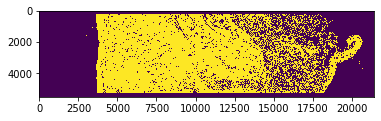

In [16]:
plt.imshow(mask)

In [17]:
#fig.savefig('./Output/muscle-mask.png', dpi = 500)

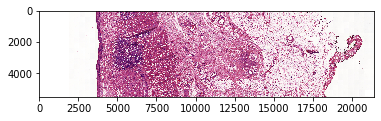

In [18]:
fig = plt.figure()
plt.imshow(img)
#fig.savefig('./Output/muscle-img.png', dpi = 500)

In [19]:
# SLIC label
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
start_time = time.time()
segments_slic = slic(img, n_segments=n_segments, compactness=10, sigma=1, enforce_connectivity=True)
regions = regionprops(segments_slic)
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
end_time = time.time()
print('Time:',end_time - start_time)
%matplotlib notebook
#plt.rcParams["figure.figsize"] = [10, 20]
fig, ax = plt.subplots()
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
ax.imshow(mark_boundaries(img, segments_slic, mode='thick', color=(50, 50, 0), outline_color=None, background_label=0))
#fig.savefig('./Output/muscle-SLIC.png', bbox_inches='tight', dpi=1000)

SLIC number of segments: 163309
Time: 106.28001594543457


<IPython.core.display.Javascript object>

SLIC number of segments: 163309


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [20]:
index, centers = CentersSLIC(regions, mask)

In [21]:
import sys

In [22]:
from src.models.MultiResSmallNetwork import MergeSmallNetworks

In [27]:
#Load model and make outputs
device = torch.device('cuda')
checkpoint = torch.load(modelpath, map_location=lambda storage, loc: storage)
model=MergeSmallNetworks(nclasses = nclasses, outputsize = n_classes).to(device)
model.load_state_dict(checkpoint["model_dict"])


<All keys matched successfully>

In [28]:
clusterids = MakeOutput(model, img, centers, patch_size, patch_size_res2)

In [29]:
regions = regionprops(segments_slic)
result = OutputMasks(mask, regions, centers, index, clusterids)

In [30]:
result.shape

(5512, 21435)

<IPython.core.display.Javascript object>


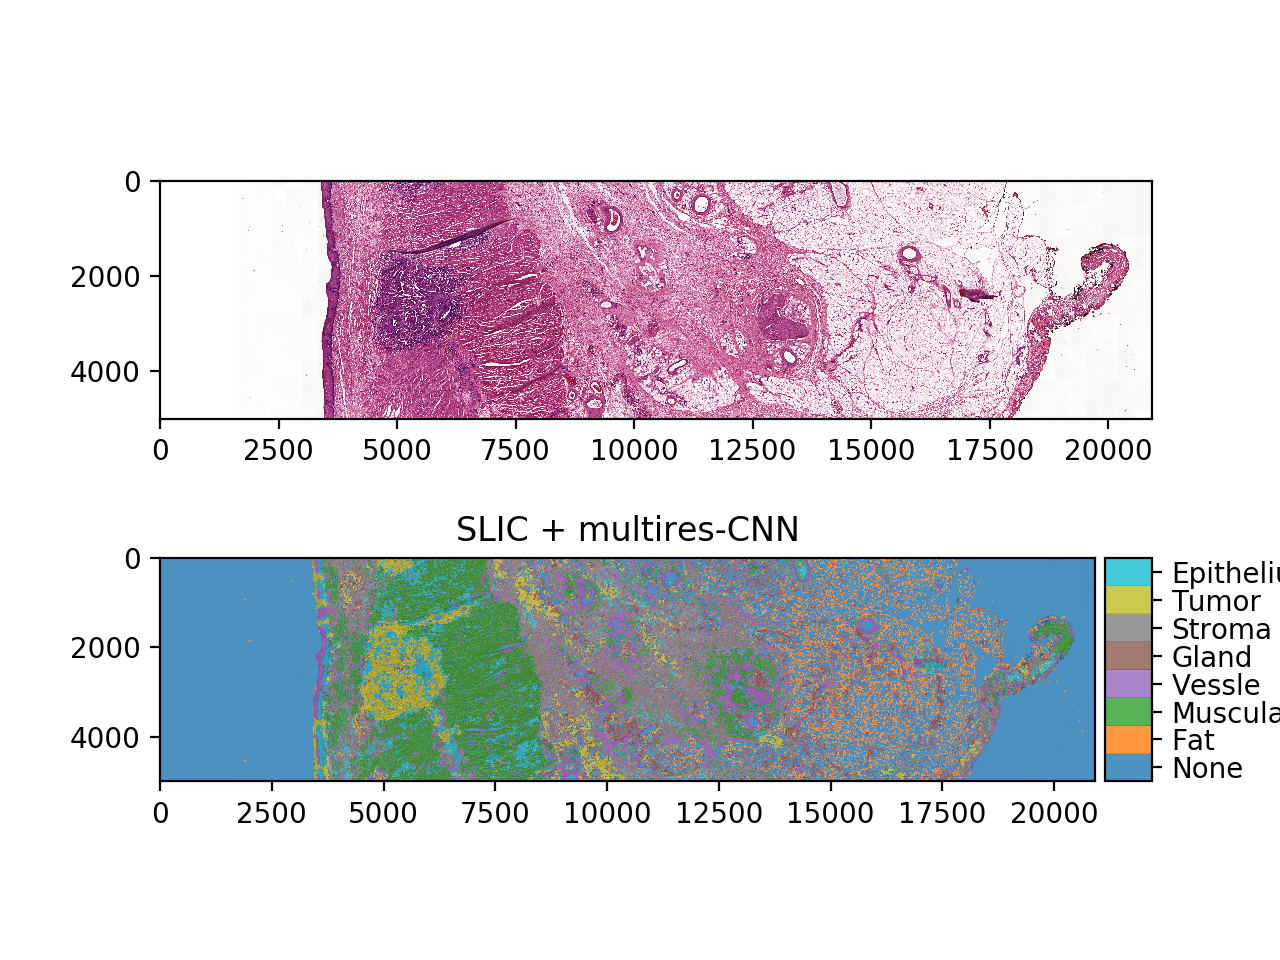

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(2, 1, gridspec_kw = {'wspace':0, 'hspace':0})
img0 = img[mirror_pad_size: - mirror_pad_size, mirror_pad_size:-mirror_pad_size, :]
result0 = result[mirror_pad_size: - mirror_pad_size, mirror_pad_size:-mirror_pad_size]

data = result0
cmap = plt.get_cmap('tab10', np.max(result0)-np.min(result0)+1)
ax[0].imshow(img0)
ax[1].imshow(img0)
cax = ax[1].imshow(data, interpolation=None, cmap=cmap, vmin = np.min(result0)-.5, vmax = np.max(result0)+.5, alpha = 0.8)
ax[1].set_title('SLIC + multires-CNN')
divider = make_axes_locatable(ax[1])
caxx = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(cax,cax = caxx, ticks=np.arange(np.min(result0),np.max(result0)+1, 1))
class_names.insert(0, 'None')
cbar.ax.set_yticklabels(class_names)  # horizontal colorbar
plt.show()

In [ ]:
fig.savefig(f'outputSLIC-{dataname}-{n_segments}.png', dpi = 700)